In [1]:
import pandas as pd
import numpy as np

import os, warnings, time

from datetime import datetime, timedelta
from scipy import stats

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
warnings.filterwarnings('ignore')

## 머신러닝 - 객실 사용 여부 관련 데이터

In [3]:
df = pd.read_csv('../Edu/code/data/hotel_bookings.csv')
df.head()

,is_canceled,deposit_type,lead_time,stays_in_weekend_nights,stays_in_week_nights,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr
0,0,No Deposit,105.0,2,5,NaN,0,0,1,0,131.50
1,0,No Deposit,303.0,2,2,NaN,0,0,0,0,73.95
2,0,No Deposit,33.0,2,3,0.0,0,0,0,0,NaN
3,0,No Deposit,48.0,0,1,0.0,0,0,1,0,80.30
4,0,No Deposit,216.0,4,7,0.0,0,0,2,0,60.90


### 1 데이터 탐색 및 결과 제시

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   is_canceled                     20000 non-null  int64  
 1   deposit_type                    20000 non-null  object 
 2   lead_time                       19995 non-null  float64
 3   stays_in_weekend_nights         20000 non-null  int64  
 4   stays_in_week_nights            20000 non-null  int64  
 5   is_repeated_guest               19642 non-null  float64
 6   previous_cancellations          20000 non-null  int64  
 7   previous_bookings_not_canceled  20000 non-null  int64  
 8   booking_changes                 20000 non-null  int64  
 9   days_in_waiting_list            20000 non-null  int64  
 10  adr                             18937 non-null  float64
dtypes: float64(3), int64(7), object(1)
memory usage: 1.7+ MB


In [5]:
df.deposit_type.unique()

array(['No Deposit', 'Refundable', 'Non Refund'], dtype=object)

In [6]:
df.describe()

,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr
count,20000.00000,19995.000000,20000.000000,20000.000000,19642.000000,20000.000000,20000.000000,20000.000000,20000.000000,18937.000000
mean,0.12000,85.978345,0.892550,2.380400,0.038133,0.032900,0.169050,0.269400,1.983950,101.410239
std,0.32497,96.427240,0.952077,1.777345,0.191521,0.455552,1.502426,0.687566,15.927212,49.245097
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.380000
25%,0.00000,11.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,68.800000
50%,0.00000,51.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,94.500000
75%,0.00000,132.000000,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,126.000000
max,1.00000,629.000000,13.000000,30.000000,1.000000,26.000000,66.000000,17.000000,379.000000,451.500000


In [7]:
df.isna().sum()

is_canceled                          0
deposit_type                         0
lead_time                            5
stays_in_weekend_nights              0
stays_in_week_nights                 0
is_repeated_guest                  358
previous_cancellations               0
previous_bookings_not_canceled       0
booking_changes                      0
days_in_waiting_list                 0
adr                               1063
dtype: int64

lead_time, is_repeated_guest, adr 변수에 결측값이 존재하는데,  
특히 adr 값에서 많이 확인되고 있다.

전체 데이터가 2만 건이므로 제거해도 무방해 보이지만,  
K-NN 등으로 대체가 가능할 수도 있으므로 확인이 필요해 보인다.

또한 is_로 시작되는 두 변수는 각각 0과 1로된 이진 변수이고,  
desposit_type은 object 타입의 명목형 변수라서 인코딩이 필요하다.

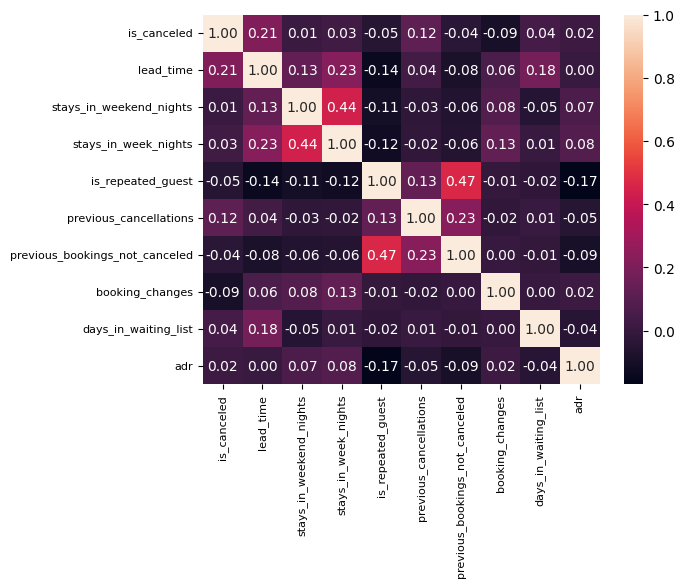

In [8]:
corr_df = df.select_dtypes(exclude=object).corr()

sns.heatmap(corr_df, annot=True, fmt='.2f')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show();

previous_bookings_not_canceled 변수와 is_repeated_guest  
변수 간 상관계수가 가장 높게 확인됐으며 다음으로는  
previous_bookings_not_canceled 변수와 previouse_cancellations  
변수이지만, 강한 상관관계라고 보기는 어렵다.

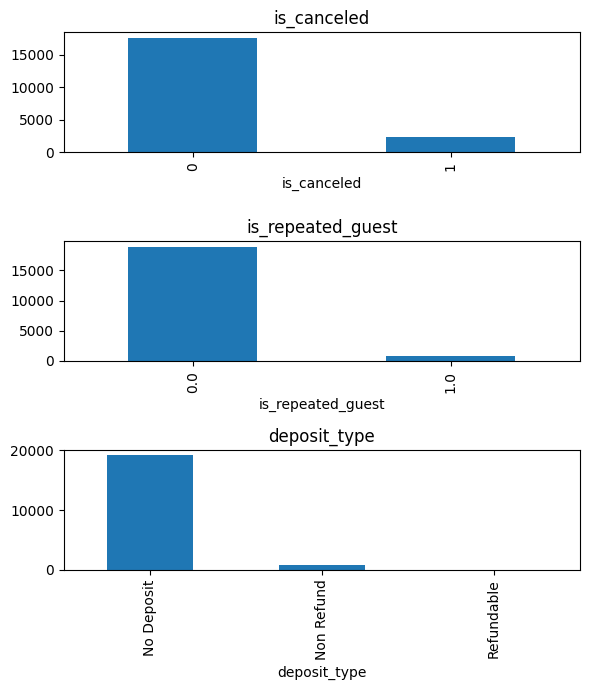

In [17]:
cat_col = ['is_canceled', 'is_repeated_guest', 'deposit_type']

plt.figure(figsize=(6, 7))

for idx, col in enumerate(cat_col):
    plt.subplot(3, 1, idx+1)
    df[col].value_counts().plot(kind='bar')
    plt.title(col)

plt.tight_layout()
plt.show();

범주형 변수들의 불균형이 심한 편인 것을 확인할 수 있다.  
그러나 실제로 충분히 관측 가능한 수준으로 보인다.

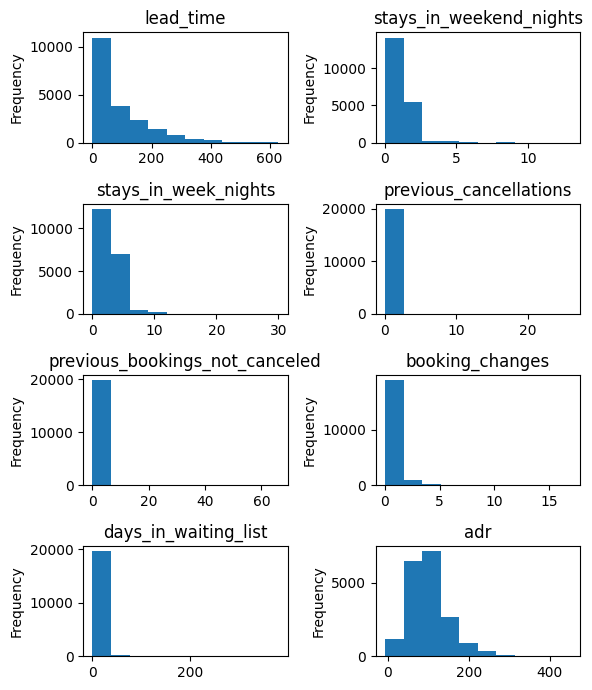

In [21]:
num_df = df.select_dtypes(exclude=object)
num_df = num_df.drop(columns=['is_canceled', 'is_repeated_guest'])

plt.figure(figsize=(6, 7))

for idx, col in enumerate(num_df):
    plt.subplot(4, 2, idx+1)
    df[col].plot(kind='hist')
    plt.title(col)

plt.tight_layout()
plt.show();

lead_time과 adr 변수를 제외한 변수는 순서형 변수로 보이므로  
종 모양을 따르지 않고, 분포가 쏠린 것을 확인할 수 있다.

In [24]:
df['previous_bookings_not_canceled'].unique()

array([ 0, 11,  2,  3,  9, 32,  4,  1, 16, 25,  7, 14, 12,  5, 27,  6, 19,
       26, 13, 17, 10, 21, 52, 24, 29, 18, 15, 66,  8, 22, 23, 20, 30, 35,
       33, 60])

In [29]:
df.loc[(df['is_repeated_guest'] == 1) & (df['previous_bookings_not_canceled'] != 0)]

,is_canceled,deposit_type,lead_time,stays_in_weekend_nights,stays_in_week_nights,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr
21,0,No Deposit,13.0,0,1,1.0,1,11,0,0,67.0
30,0,No Deposit,4.0,0,1,1.0,0,2,0,0,67.0
46,0,No Deposit,0.0,0,1,1.0,0,3,0,0,0.0
100,0,No Deposit,0.0,0,1,1.0,1,9,0,0,30.0
169,0,No Deposit,71.0,0,1,1.0,0,32,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
19095,1,No Deposit,3.0,1,2,1.0,0,1,0,0,67.0
19172,1,No Deposit,1.0,0,1,1.0,0,2,0,0,35.0
19223,1,No Deposit,1.0,0,1,1.0,4,11,0,0,0.0
19517,1,No Deposit,0.0,0,1,1.0,0,5,0,0,35.0


In [30]:
df.loc[(df['is_repeated_guest'] == 0) & (df['previous_bookings_not_canceled'] != 0)]

,is_canceled,deposit_type,lead_time,stays_in_weekend_nights,stays_in_week_nights,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr
200,0,No Deposit,8.0,0,1,0.0,0,4,0,0,25.0
604,0,No Deposit,88.0,2,5,0.0,0,1,2,0,34.0
685,0,No Deposit,88.0,2,5,0.0,0,1,0,0,236.5
691,0,No Deposit,2.0,0,0,0.0,0,1,0,0,0.0
696,0,No Deposit,157.0,2,7,0.0,0,4,0,0,209.4
...,...,...,...,...,...,...,...,...,...,...,...
17149,0,No Deposit,102.0,1,0,0.0,0,1,1,0,71.0
17184,0,No Deposit,96.0,2,5,0.0,0,2,0,0,30.0
17201,0,No Deposit,0.0,0,0,0.0,0,1,0,0,0.0
17312,0,No Deposit,17.0,1,3,0.0,0,1,0,0,36.0


상관성이 다소 높았던 is_repeated_guest와 previous_bookings_not_canceled  
변수 중 is_repeated_guest의 값을 기준으로 previous_bookings_not_canceled가  
0이 아닌 값들을 살펴보니 재방문일 경우 previous_bookings_not_canceled 변수가  
0이 아닌 경우가 많은 것으로 확인된다. 이런 부분들이 상관계수에 영향을  
준 부분들로 추측된다.

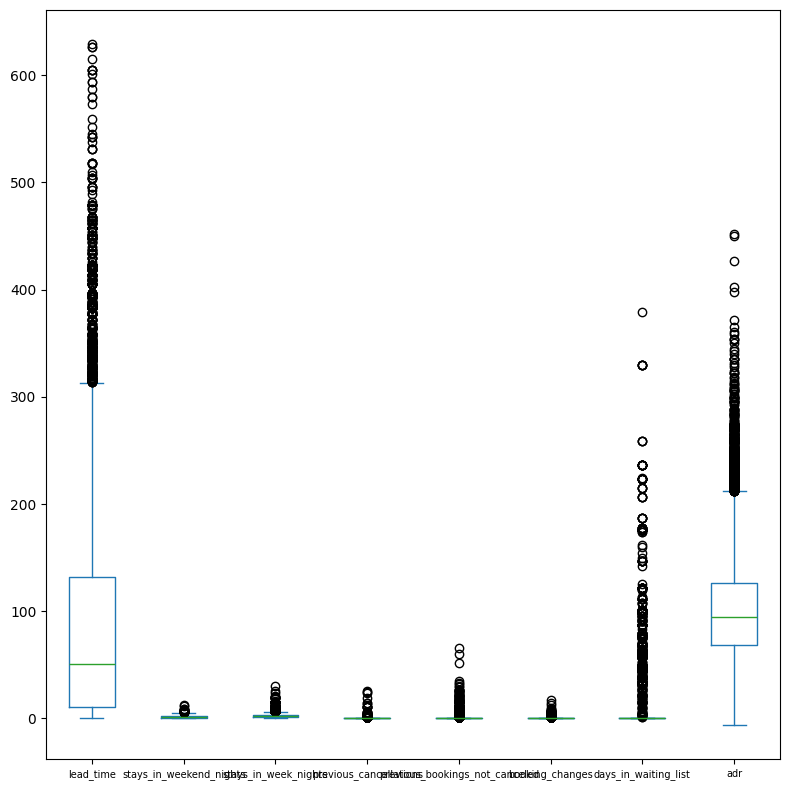

In [34]:
num_df.plot(kind='box', figsize=(8, 8))
plt.xticks(fontsize=7)
plt.tight_layout();

lead_time과 adr 변수가 연속형이라면 이상값을 확인할 필요가 있어보인다.

### 2 결측치 탐색 및 대체 방법 및 근거 제시

### 3 데이터 질 향상 방법 제안

### 4 데이터 불균형을 시각화를 통해 식별하고,
### 불균형 판단근거 작성

### 5 오버샘플링 기법을 설명하고, 비교한 뒤
### 2개 기법을 선정하고 근거 제시

### 6 기법 선정 이유 작성 및 원데이터를 포함한 3개의 데이터셋 구성

### 7 오버샘플링 데이터와 원데이터를 사용해 정확도 측면 모델 1개,
### 속도 측면 모델 1개를 선정하고 그 이유를 설명

### 8 오버샘플링 데이터와 원데이터로 각각 분류한 결과로
### 오버샘플링이 성능에 미친 영향에 대해 작성

## 통계

### 1

공장에서는 시제품의 농도(%)가 60이라고 주장하며 품질관리팀에서  
10개의 샘플을 뽑았다. 유의수준 5%에서 다음을 검정.

#### 데이터 : 52, 61, 61, 60, 26, 45, 60, 35, 60, 14

- (1) 연구가설, 귀무가설 작성
- (2) 유효한 샘플의 수 계산
- (3) 검정통계량을 구하고, 연구가설 채택 여부 작성

### 1-1

### 1-2

### 1-3

### 2

코로나 시계열 데이터 활용

- (1) ACF를 사용해 distancd를 계산
- (2) 계층적 군집분석을 위해 덴드로그램 작성

In [9]:
covid = pd.read_csv('../Edu/code/data/서울특별시 코로나19.csv')
covid.head()

,날짜,종로구,중구,용산구,성동구,광진구,동대문구,중랑구,성북구,강북구,...,강서구,구로구,금천구,영등포구,동작구,관악구,서초구,강남구,송파구,강동구
0,2022-03-30,37261,33753,55376,81018,96008,95433,103288,116862,75118,...,148359,109973,63687,110293,106238,132305,104368,136200,176765,121926
1,2022-03-29,36216,32835,53872,79030,93474,92993,100255,113609,72934,...,143573,106162,61840,106171,102955,127626,100529,132333,172292,118842
2,2022-03-28,35276,31878,52391,76802,91030,90277,97419,110583,70754,...,139633,103573,59946,104109,100665,124805,98869,128813,167386,115846
3,2022-03-27,34879,31577,51652,76108,89876,89302,96359,109500,70003,...,137908,102610,59393,102916,99426,123374,96873,126296,165373,113549
4,2022-03-26,34061,30903,50720,74178,87770,87345,93690,106437,68329,...,134285,99938,57925,100349,96989,120413,95124,123992,161650,110649


### 2-1

### 2-2

### 3

사회과학, 자연과학, 공학 세 개 학과의 평점조사표를 보고  
학과와 성적이 관계있는지 검정

- (1) 연구가설, 귀무가설 작성
- (2) 학과와 성적이 독립일 때의 기댓값
- (3) 검정통계량을 구하고 연구가설 채택 여부 작성

### 3-1

### 3-2

### 3-3